# Mapping Covid in Canada

### Following tutorial:

https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d

__Source files:__

Health region boundaries (2017): https://www150.statcan.gc.ca/n1/pub/82-402-x/2017001/hrbf-flrs-eng.htm

Health region codes (2011): https://www150.statcan.gc.ca/n1/pub/82-402-x/2011001/app-ann/app1-ann1-eng.htm

COVID cases/deaths (2020-04-14): https://github.com/ishaberry/Covid19Canada

StatsCanada relational information: https://www150.statcan.gc.ca/n1/pub/82-402-x/2017001/gui-eng.htm#a4

__Goal:__

Find COVID19 cases and deaths by population density and plot on a Choropleth. https://www.canadiangeographic.ca/article/mapping-covid-19-cases-canada-capita

__Approach:__

Find current CoViD-19 cases (and deaths) by health region. Determine population of each health region by census divisions which are concurrent, and plot CV-19 intensity.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

In [2]:
!ls

92-160-g2016002-eng.pdf
Comprehensive_HR2017_16.csv
HR_000a17a_e_Dec2017.cpg
HR_000a17a_e_Dec2017.dbf
HR_000a17a_e_Dec2017.prj
HR_000a17a_e_Dec2017.shp
HR_000a17a_e_Dec2017.shx
Mapping Covid in Canada.ipynb
cases.csv
census_division.html
mortality.csv


__Covid 19 case information__

In [3]:
#covid cases based on health region

cases = pd.read_csv('cases.csv')
mort = pd.read_csv('mortality.csv')

In [4]:
cases.shape, mort.shape

((27892, 16), (967, 12))

In [5]:
cases.head()

,case_id,provincial_case_id,age,sex,health_region,province,country,date_report,report_week,travel_yn,travel_history_country,locally_acquired,case_source,additional_info,additional_source,method_note
0,1,1,50-59,Male,Toronto,Ontario,Canada,25-01-2020,19-01-2020,1,China,NaN,(1) https://news.ontario.ca/mohltc/en/2020/01/...,NaN,NaN,0.0
1,2,2,50-59,Female,Toronto,Ontario,Canada,27-01-2020,26-01-2020,1,China,NaN,(1) https://news.ontario.ca/mohltc/en/2020/01/...,Travel and Close Contact,NaN,0.0
2,3,1,40-49,Male,Vancouver Coastal,BC,Canada,28-01-2020,26-01-2020,1,China,NaN,https://news.gov.bc.ca/releases/2020HLTH0015-0...,NaN,NaN,NaN
3,4,3,20-29,Female,Middlesex-London,Ontario,Canada,31-01-2020,26-01-2020,1,China,NaN,(1) https://news.ontario.ca/mohltc/en/2020/01/...,NaN,NaN,0.0
4,5,2,50-59,Female,Vancouver Coastal,BC,Canada,04-02-2020,02-02-2020,0,NaN,Close Contact,https://news.gov.bc.ca/releases/2020HLTH0023-0...,The individual had close contact with family v...,NaN,NaN


In [6]:
mort.head()

,death_id,province_death_id,case_id,age,sex,health_region,province,country,date_death_report,death_source,additional_info,additional_source
0,1,1,60.0,80-89,Male,Vancouver Coastal,BC,Canada,08-03-2020,https://news.gov.bc.ca/releases/2020HLTH0068-0...,Lynn Valley Resident,NaN
1,2,1,477.0,70-79,Male,Simcoe Muskoka,Ontario,Canada,11-03-2020,https://www.nationalobserver.com/2020/03/17/ne...,Was being treated at Royal Victoria Regional H...,NaN
2,3,2,NaN,Not Reported,Not Reported,Vancouver Coastal,BC,Canada,16-03-2020,https://news.gov.bc.ca/releases/2020HLTH0086-0...,Lynn Valley Resident,NaN
3,4,3,NaN,Not Reported,Not Reported,Vancouver Coastal,BC,Canada,16-03-2020,https://news.gov.bc.ca/releases/2020HLTH0086-0...,Lynn Valley Resident,NaN
4,5,4,NaN,Not Reported,Not Reported,Vancouver Coastal,BC,Canada,16-03-2020,https://news.gov.bc.ca/releases/2020HLTH0086-0...,Lynn Valley Resident,NaN


Case and mortality information is reported on an individual bases by health region for each infection. Will need to find current population for health region, and merge with a count of cases/health region. A reasonable first step is to create a list of cases for each health region.

Each record includes information on str health region, province. No HRID is given.

In [7]:
cases_by_HR = cases.groupby(['health_region', 'province']).size().reset_index(name = 'CV19_infections')
deaths_by_HR = mort.groupby(['health_region', 'province']).size().reset_index(name = "CV19_deaths")

In [8]:
cases_by_HR.tail()

,health_region,province,CV19_infections
89,Zone 4 (Edmundston area),New Brunswick,7
90,Zone 4 - Central,Nova Scotia,34
91,Zone 5 (Campbellton area),New Brunswick,11
92,Zone 6 (Bathurst area),New Brunswick,1
93,Zone 7 (Miramichi area),New Brunswick,2


In [9]:
HR_cases = (cases_by_HR['health_region'].unique())
#HR_cases

In [10]:
deaths_by_HR.tail()

,health_region,province,CV19_deaths
50,Windsor-Essex,Ontario,13
51,Winnipeg,Manitoba,4
52,York,Ontario,41
53,Zone 3 - Eastern,Nova Scotia,2
54,Zone 4 - Central,Nova Scotia,1


In [11]:
HR_deaths = (deaths_by_HR['health_region'].unique())
#HR_deaths

In [12]:
set(HR_deaths).issubset(set(HR_cases))

True

94 individual health regions represented for cases, and 54 for deaths. This seems reasonable. As unique values in deaths as a set in cases.

In [13]:
#Join case and death data on multiple keys, keeping all entries, and filling Nan's with 0

covid_data = pd.merge(cases_by_HR, deaths_by_HR, how = 'outer', 
                      on = ['health_region', 'province']).fillna(value = 0)

covid_data

,health_region,province,CV19_infections,CV19_deaths
0,Abitibi-Témiscamingue,Quebec,138.0,2.0
1,Algoma,Ontario,10.0,0.0
2,Bas-Saint-Laurent,Quebec,34.0,1.0
3,Brant,Ontario,67.0,1.0
4,Calgary,Alberta,1242.0,32.0
...,...,...,...,...
92,Zone 6 (Bathurst area),New Brunswick,1.0,0.0
93,Zone 7 (Miramichi area),New Brunswick,2.0,0.0
94,Not Reported,BC,0.0,14.0
95,Not Reported,Quebec,0.0,4.0


In [14]:
#drop rows with no health region
to_drop = ['Not Reported', 'Repatriated']
covid_data = covid_data[~covid_data['health_region'].isin(to_drop)]

covid_data

,health_region,province,CV19_infections,CV19_deaths
0,Abitibi-Témiscamingue,Quebec,138.0,2.0
1,Algoma,Ontario,10.0,0.0
2,Bas-Saint-Laurent,Quebec,34.0,1.0
3,Brant,Ontario,67.0,1.0
4,Calgary,Alberta,1242.0,32.0
...,...,...,...,...
89,Zone 4 (Edmundston area),New Brunswick,7.0,0.0
90,Zone 4 - Central,Nova Scotia,34.0,1.0
91,Zone 5 (Campbellton area),New Brunswick,11.0,0.0
92,Zone 6 (Bathurst area),New Brunswick,1.0,0.0


Current case and deaths from Covid-19 broken down by health region and province.

### Geographic data.

Will need to break down by health region, and get population data. Will need .SHP file for plotting.

In [15]:
#geographic data on health divisions
health_map = gpd.read_file('HR_000a17a_e_Dec2017.shp')

#len(health_map)
health_map.tail()

,HR_UID,ENG_LABEL,FRE_LABEL,Shape_Leng,Shape_Area,geometry
107,5952,Northern Interior Health Service Delivery Area,Northern Interior Health Service Delivery Area,3.923776e+06,1.739290e+11,"POLYGON ((4300215.720 2938645.711, 4300225.766..."
108,5953,Northeast Health Service Delivery Area,Northeast Health Service Delivery Area,2.581473e+06,1.633987e+11,"POLYGON ((4331359.620 3183185.929, 4331928.951..."
109,6001,Yukon,Yukon,4.126711e+06,4.566648e+11,"POLYGON ((4561932.471 4312865.174, 4564007.580..."
110,6101,Northwest Territories,Territoires du Nord-Ouest,1.017360e+07,2.484319e+12,"POLYGON ((5689672.257 4324508.314, 5685498.029..."
111,6201,Nunavut,Nunavut,1.444274e+07,4.740612e+12,"POLYGON ((7297737.369 3983558.454, 7316653.440..."


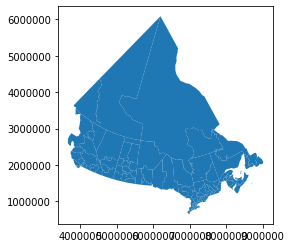

In [16]:
health_map.plot()

In [17]:
len(health_map['HR_UID'].unique())

112

In [18]:
#Health region and census relational information

relational = pd.read_csv('Comprehensive_HR2017_16.csv')
relational.head()

,dbuid2016,csduid2016,hruid2017,hrname_english,hrname_french,dbpop2016
0,10010165001,1001519,1011,Eastern Regional Health Authority,Eastern Regional Health Authority,160.0
1,10010165002,1001519,1011,Eastern Regional Health Authority,Eastern Regional Health Authority,25.0
2,10010165006,1001519,1011,Eastern Regional Health Authority,Eastern Regional Health Authority,268.0
3,10010165007,1001519,1011,Eastern Regional Health Authority,Eastern Regional Health Authority,53.0
4,10010166001,1001519,1011,Eastern Regional Health Authority,Eastern Regional Health Authority,71.0


In [19]:
#determine if population will need to be adjusted
pop = relational['dbpop2016'].sum()
pop

35151728.0

In [20]:
#dbuid2016 (database id?)
print('dbuid2016: ' + str(len(relational['dbuid2016'].unique())))

#csduid2016 (census subdivisions)
print('csduid2016: ' + str(len(relational['csduid2016'].unique())))

#hruid2017 (health regions)
print('hruid2017: ' + str(len(relational['hruid2017'].unique())))

dbuid2016: 489905
csduid2016: 5162
hruid2017: 112


In [21]:
#don't need database ID or census id
relational = relational.drop(columns = ['dbuid2016', 'hrname_french', 'csduid2016'])

#rename columns for each of use
relational = relational.rename(columns = {'hrname_english': 'health_region', 'hruid2017' : 'HR_UID', 
                                          'dbpop2016' : 'population'})
relational.head()

,HR_UID,health_region,population
0,1011,Eastern Regional Health Authority,160.0
1,1011,Eastern Regional Health Authority,25.0
2,1011,Eastern Regional Health Authority,268.0
3,1011,Eastern Regional Health Authority,53.0
4,1011,Eastern Regional Health Authority,71.0


In [22]:
covid_data.head()

,health_region,province,CV19_infections,CV19_deaths
0,Abitibi-Témiscamingue,Quebec,138.0,2.0
1,Algoma,Ontario,10.0,0.0
2,Bas-Saint-Laurent,Quebec,34.0,1.0
3,Brant,Ontario,67.0,1.0
4,Calgary,Alberta,1242.0,32.0


In [23]:
#get unique province codes
covid_data['province'].unique()

array(['Quebec', 'Ontario', 'Alberta', 'NL', 'Saskatchewan', 'BC',
       'Manitoba', 'NWT', 'PEI', 'Yukon', 'New Brunswick', 'Nova Scotia'],
      dtype=object)

In [24]:
#dict for province codes
prov_code = {10:'NL', 11:"PEI", 12:"Nova Scotia", 13:"New Brunswick", 24:'Quebec',
             35:"Ontario", 46:'Manitoba', 47:'Saskatchewan', 48:"Alberta",
             59:"BC", 60:"Yukon", 61:"NWT", 62:"Nunavut"}

In [25]:
prov_code

{10: 'NL',
 11: 'PEI',
 12: 'Nova Scotia',
 13: 'New Brunswick',
 24: 'Quebec',
 35: 'Ontario',
 46: 'Manitoba',
 47: 'Saskatchewan',
 48: 'Alberta',
 59: 'BC',
 60: 'Yukon',
 61: 'NWT',
 62: 'Nunavut'}

In [26]:
#Pull province code out of HR_UID
relational['prov_code'] = relational['HR_UID'].astype(str)
relational['prov_code'] = relational['prov_code'].str.slice(0,2).astype(int)

In [27]:
#collapse dataframe onto unique HR_UID, adding all subregions
relational = relational.groupby(['HR_UID', 'health_region', 'prov_code'])['population'].agg('sum').reset_index()

len(relational)

112

In [28]:
#Add province information
relational['province'] = relational['prov_code'].map(prov_code)

In [29]:
relational["health_region"] = relational['health_region'].str.replace(' Regional','')
relational["health_region"] = relational['health_region'].str.replace(' Health Unit','')
relational["health_region"] = relational['health_region'].str.replace(' Health Authority','')
relational["health_region"] = relational['health_region'].str.replace(' Health Service Delivery Area','')
relational["health_region"] = relational['health_region'].str.replace(' Health','')
relational["health_region"] = relational['health_region'].str.replace('Région de la ','')
relational["health_region"] = relational['health_region'].str.replace("Région de l'",'')
relational["health_region"] = relational['health_region'].str.replace('Région de ','')
relational["health_region"] = relational['health_region'].str.replace('Région des ','')
relational["health_region"] = relational['health_region'].str.replace(' et du Centre-du-Québec','')
relational["health_region"] = relational['health_region'].str.replace('Région du ','')
relational["health_region"] = relational['health_region'].str.replace('City of ','')
relational["health_region"] = relational['health_region'].str.replace(' Vancouver Island',' Island')
relational["health_region"] = relational['health_region'].str.replace(' Zone','')
relational["health_region"] = relational['health_region'].str.replace(', ',' ')
relational["health_region"] = relational['health_region'].str.replace('The District of ','')
relational["health_region"] = relational['health_region'].str.replace(" Qu'Appelle",'')
relational["health_region"] = relational['health_region'].str.replace("Northwest Territories",'NWT')
relational["health_region"] = relational['health_region'].str.replace("Vancouver",'Vancouver Coastal')
relational["health_region"] = relational['health_region'].str.replace(" Country",'')
relational["health_region"] = relational['health_region'].str.replace(" County",'')
relational["health_region"] = relational['health_region'].str.replace(" Counties",'')
relational["health_region"] = relational['health_region'].str.replace(" and District",'')
relational["health_region"] = relational['health_region'].str.replace(" District",'')      
relational["health_region"] = relational['health_region'].str.replace(" Area",'')          
relational["health_region"] = relational['health_region'].str.replace("–City",'')      
relational["health_region"] = relational['health_region'].str.replace("Northern Interior",'Interior')   
relational["health_region"] = relational['health_region'].str.replace(" and",'')   
relational["health_region"] = relational['health_region'].str.replace(" &",'')
relational["health_region"] = relational['health_region'].str.replace("—Lac-Saint-Jean",'')
relational["health_region"] = relational['health_region'].str.replace("—",'-')
relational["health_region"] = relational['health_region'].str.replace("Yukon ",'Yukon')
relational["health_region"] = relational['health_region'].str.replace("Pine Ridge",'Pineridge')
relational["health_region"] = relational['health_region'].str.replace("Wellington-Dufferin-Guelph",'Wellington Dufferin Guelph')

covid_data["health_region"] = covid_data['health_region'].str.replace(" &",'') 
covid_data["health_region"] = covid_data['health_region'].str.replace(" and",'')
covid_data["health_region"] = covid_data['health_region'].str.replace(' Health','')


C:\Users\djord\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\djord\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\djord\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [30]:
relational_set = relational['health_region'].unique()
relational_set

array(['Eastern', 'Central', 'Western', 'Labrador-Grenfell',
       'Prince Edward Island', 'Zone 1 - Western', 'Zone 2 - Northern',
       'Zone 3 - Eastern', 'Zone 4 - Central', 'Zone 1 (Moncton area)',
       'Zone 2 (Saint John area)', 'Zone 3 (Fredericton area)',
       'Zone 4 (Edmundston area)', 'Zone 5 (Campbellton area)',
       'Zone 6 (Bathurst area)', 'Zone 7 (Miramichi area)',
       'Bas-Saint-Laurent', 'Saguenay', 'Capitale-Nationale', 'Mauricie',
       'Estrie', 'Montréal', 'Outaouais', 'Abitibi-Témiscamingue',
       'Côte-Nord', 'Nord-du-Québec', 'Gaspésie-Îles-de-la-Madeleine',
       'Chaudière-Appalaches', 'Laval', 'Lanaudière', 'Laurentides',
       'Montérégie', 'Nunavik', 'Terres-Cries-de-la-Baie-James', 'Algoma',
       'Brant', 'Durham', 'Elgin-St. Thomas', 'Grey Bruce',
       'Haldimand-Norfolk', 'Haliburton Kawartha Pineridge', 'Halton',
       'Hamilton', 'Hastings Prince Edward', 'Huron', 'Chatham-Kent',
       'Kingston Frontenac Lennox Addington', 'Lam

In [31]:
covid_set = covid_data['health_region'].unique()
covid_set

array(['Abitibi-Témiscamingue', 'Algoma', 'Bas-Saint-Laurent', 'Brant',
       'Calgary', 'Capitale-Nationale', 'Central', 'Chatham-Kent',
       'Chaudière-Appalaches', 'Côte-Nord', 'Durham', 'Eastern',
       'Edmonton', 'Estrie', 'Far North', 'Fraser',
       'Gaspésie-Îles-de-la-Madeleine', 'Grey Bruce', 'Haldimand-Norfolk',
       'Haliburton Kawartha Pineridge', 'Halton', 'Hamilton',
       'Hastings Prince Edward', 'Huron Perth', 'Interior',
       'Interlake-Eastern', 'Island',
       'Kingston Frontenac Lennox Addington', 'Labrador-Grenfell',
       'Lambton', 'Lanaudière', 'Laurentides', 'Laval',
       'Leeds Grenville Lanark', 'Mauricie', 'Middlesex-London',
       'Montréal', 'Montérégie', 'NWT', 'Niagara', 'Nord-du-Québec',
       'North', 'North Bay Parry Sound', 'Northern', 'Northwestern',
       'Nunavik', 'Ottawa', 'Outaouais', 'Peel', 'Peterborough',
       'Porcupine', 'Prairie Mountain', 'Prince Edward Island', 'Regina',
       'Renfrew', 'Saguenay', 'Saskatoon', '

In [32]:
print(np.setdiff1d(covid_set, relational_set))

['Far North' 'Fraser' 'Huron Perth' 'Island' 'North' 'Southwestern']


In [33]:
covid_by_HR = pd.merge(relational, covid_data, on = ['health_region', 'province'])
covid_by_HR['HR_UID'] = covid_by_HR['HR_UID'].astype(str)
covid_by_HR

,HR_UID,health_region,prov_code,population,province,CV19_infections,CV19_deaths
0,1011,Eastern,10,313267.0,NL,227.0,3.0
1,1012,Central,10,92690.0,NL,8.0,0.0
2,1013,Western,10,77687.0,NL,3.0,0.0
3,1014,Labrador-Grenfell,10,36072.0,NL,6.0,0.0
4,1100,Prince Edward Island,11,142907.0,PEI,25.0,0.0
...,...,...,...,...,...,...,...
75,4834,Edmonton,48,1320798.0,Alberta,402.0,7.0
76,5932,Vancouver Coastal,59,649028.0,BC,658.0,42.0
77,5952,Interior,59,140452.0,BC,141.0,0.0
78,6001,Yukon,60,35874.0,Yukon,8.0,0.0


In [34]:
type(health_map['HR_UID'][0]), type(covid_by_HR['HR_UID'][0])

(str, str)

In [35]:
covid_data = pd.merge(health_map, covid_by_HR, how = 'outer', on=['HR_UID'])

In [36]:
len(covid_data)

112

In [37]:
covid_data['CV19_infections/1000_persons'] = covid_data['CV19_infections']/covid_data['population']*1000
covid_data['CV19_deaths/1000_persons'] = covid_data['CV19_deaths']/covid_data['population']*1000

In [38]:
covid_data

,HR_UID,ENG_LABEL,FRE_LABEL,Shape_Leng,Shape_Area,geometry,health_region,prov_code,population,province,CV19_infections,CV19_deaths,CV19_infections/1000_persons,CV19_deaths/1000_persons
0,1307,Zone 7 (Miramichi area),Zone 7 (région de Miramichi),5.332048e+05,1.085210e+10,"POLYGON ((8203862.017 1654073.583, 8211123.906...",Zone 7 (Miramichi area),13.0,43561.0,New Brunswick,2.0,0.0,0.045913,0.000000
1,2401,Région du Bas-Saint-Laurent,Région du Bas-Saint-Laurent,9.786369e+05,2.848374e+10,"POLYGON ((7983960.509 1783925.871, 7985523.191...",Bas-Saint-Laurent,24.0,197385.0,Quebec,34.0,1.0,0.172252,0.005066
2,2402,Région du Saguenay—Lac-Saint-Jean,Région du Saguenay—Lac-Saint-Jean,1.744496e+06,1.056790e+11,"POLYGON ((7633344.703 2074566.791, 7635455.789...",Saguenay,24.0,276368.0,Quebec,170.0,5.0,0.615122,0.018092
3,2403,Région de la Capitale-Nationale,Région de la Capitale-Nationale,7.764856e+05,2.139743e+10,"POLYGON ((7811516.777 1616612.783, 7813390.280...",Capitale-Nationale,24.0,729997.0,Quebec,511.0,15.0,0.700003,0.020548
4,2404,Région de la Mauricie et du Centre-du-Québec,Région de la Mauricie et du Centre-du-Québec,1.511641e+06,4.782086e+10,"POLYGON ((7459301.751 1597664.723, 7459403.646...",Mauricie,24.0,508511.0,Quebec,830.0,43.0,1.632216,0.084561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,5952,Northern Interior Health Service Delivery Area,Northern Interior Health Service Delivery Area,3.923776e+06,1.739290e+11,"POLYGON ((4300215.720 2938645.711, 4300225.766...",Interior,59.0,140452.0,BC,141.0,0.0,1.003902,0.000000
108,5953,Northeast Health Service Delivery Area,Northeast Health Service Delivery Area,2.581473e+06,1.633987e+11,"POLYGON ((4331359.620 3183185.929, 4331928.951...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,6001,Yukon,Yukon,4.126711e+06,4.566648e+11,"POLYGON ((4561932.471 4312865.174, 4564007.580...",Yukon,60.0,35874.0,Yukon,8.0,0.0,0.223003,0.000000
110,6101,Northwest Territories,Territoires du Nord-Ouest,1.017360e+07,2.484319e+12,"POLYGON ((5689672.257 4324508.314, 5685498.029...",NWT,61.0,41786.0,NWT,5.0,0.0,0.119657,0.000000


In [39]:
covid_data_2 = covid_data.copy(deep = True)
covid_data_2

,HR_UID,ENG_LABEL,FRE_LABEL,Shape_Leng,Shape_Area,geometry,health_region,prov_code,population,province,CV19_infections,CV19_deaths,CV19_infections/1000_persons,CV19_deaths/1000_persons
0,1307,Zone 7 (Miramichi area),Zone 7 (région de Miramichi),5.332048e+05,1.085210e+10,"POLYGON ((8203862.017 1654073.583, 8211123.906...",Zone 7 (Miramichi area),13.0,43561.0,New Brunswick,2.0,0.0,0.045913,0.000000
1,2401,Région du Bas-Saint-Laurent,Région du Bas-Saint-Laurent,9.786369e+05,2.848374e+10,"POLYGON ((7983960.509 1783925.871, 7985523.191...",Bas-Saint-Laurent,24.0,197385.0,Quebec,34.0,1.0,0.172252,0.005066
2,2402,Région du Saguenay—Lac-Saint-Jean,Région du Saguenay—Lac-Saint-Jean,1.744496e+06,1.056790e+11,"POLYGON ((7633344.703 2074566.791, 7635455.789...",Saguenay,24.0,276368.0,Quebec,170.0,5.0,0.615122,0.018092
3,2403,Région de la Capitale-Nationale,Région de la Capitale-Nationale,7.764856e+05,2.139743e+10,"POLYGON ((7811516.777 1616612.783, 7813390.280...",Capitale-Nationale,24.0,729997.0,Quebec,511.0,15.0,0.700003,0.020548
4,2404,Région de la Mauricie et du Centre-du-Québec,Région de la Mauricie et du Centre-du-Québec,1.511641e+06,4.782086e+10,"POLYGON ((7459301.751 1597664.723, 7459403.646...",Mauricie,24.0,508511.0,Quebec,830.0,43.0,1.632216,0.084561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,5952,Northern Interior Health Service Delivery Area,Northern Interior Health Service Delivery Area,3.923776e+06,1.739290e+11,"POLYGON ((4300215.720 2938645.711, 4300225.766...",Interior,59.0,140452.0,BC,141.0,0.0,1.003902,0.000000
108,5953,Northeast Health Service Delivery Area,Northeast Health Service Delivery Area,2.581473e+06,1.633987e+11,"POLYGON ((4331359.620 3183185.929, 4331928.951...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,6001,Yukon,Yukon,4.126711e+06,4.566648e+11,"POLYGON ((4561932.471 4312865.174, 4564007.580...",Yukon,60.0,35874.0,Yukon,8.0,0.0,0.223003,0.000000
110,6101,Northwest Territories,Territoires du Nord-Ouest,1.017360e+07,2.484319e+12,"POLYGON ((5689672.257 4324508.314, 5685498.029...",NWT,61.0,41786.0,NWT,5.0,0.0,0.119657,0.000000


## Map time!

In [40]:
max_inf = covid_data['CV19_infections/1000_persons'].max()
min_inf = covid_data['CV19_infections/1000_persons'].min()

print (max_inf, min_inf)

3.412898986840669 0.0051446680660163805


In [41]:
max_death = covid_data['CV19_deaths/1000_persons'].max()
min_death = covid_data['CV19_deaths/1000_persons'].min()

print (max_death, min_death)

0.18427209729566738 0.0


C:\Users\djord\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


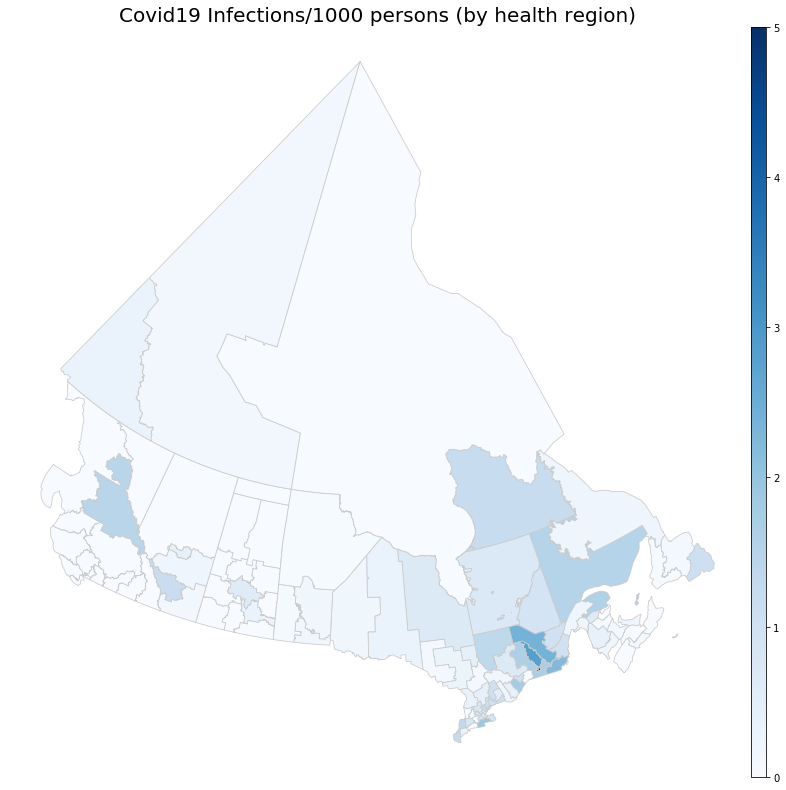

In [42]:
inf_rate = 'CV19_infections/1000_persons'
inf_rate_max, inf_rate_min = 5.0, 0.0

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, figsize = (12,11))

plt.tight_layout()

ax.axis('off')
ax.set_title('Covid19 Infections/1000 persons (by health region)', 
            fontdict = {'fontsize': '20', 'fontweight': '3'})

sm1 = plt.cm.ScalarMappable(cmap = 'Blues',
                           norm = plt.Normalize(vmin=inf_rate_min,
                                               vmax=inf_rate_max))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)

sm1._A = []

cbar = fig.colorbar(sm1, cax=cax)

covid_data.plot(column=inf_rate, cmap = 'Blues', linewidth = 0.8,
                ax=ax, edgecolor='0.8')



C:\Users\djord\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


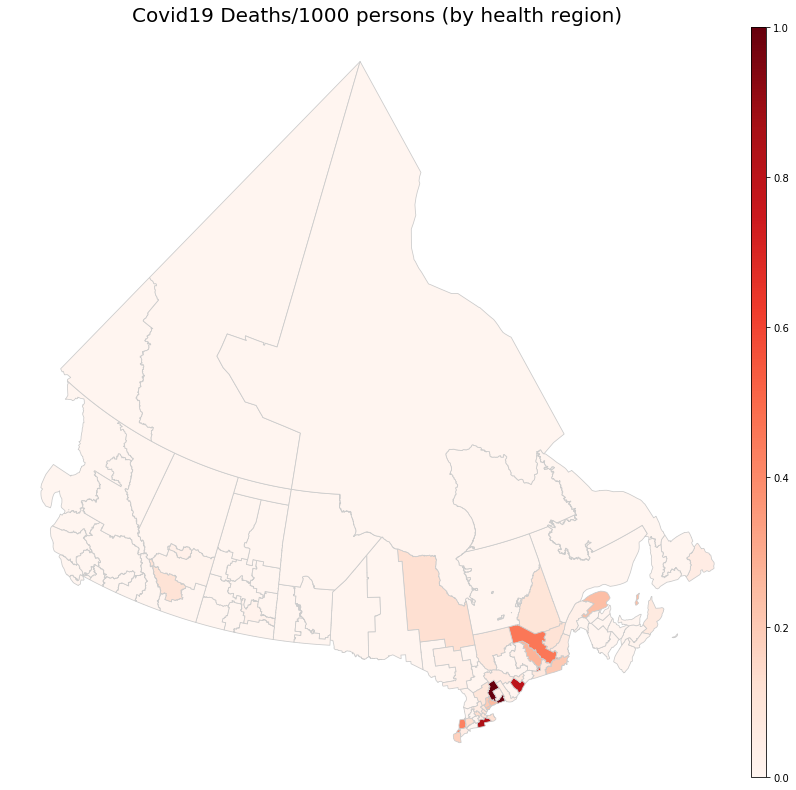

In [43]:
death_rate = 'CV19_deaths/1000_persons'
death_rate_max, death_rate_min = 1.0, 0.0

fig, ax = plt.subplots(1, figsize = (12,11))

plt.tight_layout()

ax.axis('off')
ax.set_title('Covid19 Deaths/1000 persons (by health region)', 
            fontdict = {'fontsize': '20', 'fontweight': '3'})

sm2 = plt.cm.ScalarMappable(cmap = 'Reds',
                           norm = plt.Normalize(vmin=death_rate_min,
                                               vmax=death_rate_max))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)

sm2._A = []

cbar = fig.colorbar(sm2, cax=cax)

covid_data_2.plot(column=death_rate, cmap = 'Reds', linewidth = 0.8,
                ax=ax, edgecolor='0.8')



### Learnings:

Make sure that the indexing on the .shp file is easily matched. It can be very difficult to pull in data from multiple sources and have the indexes match. 90% of the time on this project was munging and collecting data.

Knowledge of the health region naming structure was also useful.